# Quickstart Example with Synthetic REC Simulation and Dataset (Data Collection)
This notebook provides an example of visualizing the logged dataset collected on an REC environment.

This example on consists of the following case:
1. Discrete Action Case

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  
\* Also, our data collection module is highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [52]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import d3rlpy
print(d3rlpy.__version__)


1.1.1


In [54]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [55]:
# delete later
import sys
sys.path.append('/recgym')
sys.path.append('../')
sys.path.append('../../')

In [56]:
# import OFRL modules
import ofrl
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import recgym
from recgym.function import inner_reward_function
from recgym.function import user_preference_dynamics
from recgym.rec import RECEnv

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

In [57]:
import pickle
from dataclasses import dataclass
from typing import Tuple, Union, Optional
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [58]:
# version
print(ofrl.__version__)

0.0.0


In [59]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 0. Description of Synthetic REC Simulation Environment

To begin with, we briefly describe the basic usage of the environment.

#### RL setup for REC
In REC, the objective of the RL agent is to maximize reward

We often formulate this REC problem as the following Markov Decision Process (MDP):
- `state`: 
   - make the initial state the user_feature of the chosen user
   - update state with state_transition_function
- `action`: selected from n_items
- `reward`: rewards are determined by reward_function

Let's see how it works!

In [60]:
# setup environment
env = RECEnv(
    reward_function = inner_reward_function,
    state_transition_function = user_preference_dynamics,
)

In [61]:
agent = DiscreteEpsilonGreedyHead(
      base_policy = DiscreteRandomPolicy(),
      name = 'random',
      n_actions = env.n_items,
      epsilon = 1. ,
      random_state = random_state, 
)

In [62]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [63]:
# state 
print(obs.shape)
print(obs)

(5,)
[ 0.89579574 -0.25768932 -0.76433993 -0.20757989 -0.51136612]


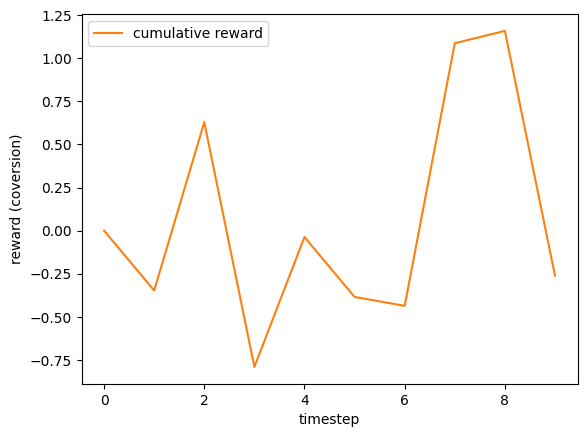

In [64]:
# let's visualize the transition of the remaining budget and cumulative reward
# our goal is to obtain a policy (or an agent) that maximizes the cumulative reward using RL.  
# for more visualization, please see the appendix.
obs, info = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.sample_action_online(obs)
    obs, reward, done, truncated, info = env.step(action)
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
plt.show()

For more about the environmental configuration , please refer to [examples/quickstart/REC_synthetic_customize_env.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_customize_env.ipynb).

## 1. Discrete Action Case
Here, we present how to collect logged data by a behavior policy in the case of discrete action.

The procedure requires two steps:

1. Learn a base deterministic policy
2. Convert the deterministic policy into a stochastic policy.

Below, we first learn a deterministic policy using [d3rlpy](https://github.com/takuseno/d3rlpy).

In [65]:
# standardized environment for discrete action
env = RECEnv(
    reward_function = inner_reward_function, 
    state_transition_function = user_preference_dynamics,
)

In [66]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

In [67]:
# learn a base deterministic policy for data collection
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [68]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-01-09 22:54.19 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230109225419
2023-01-09 22:54.19 [debug    ] Building model...
2023-01-09 22:54.19 [debug    ] Model has been built.
2023-01-09 22:54.19 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230109225419/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-01-09 22:54.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230109225419/model_1000.pt
2023-01-09 22:54.20 [info     ] DoubleDQN_online_20230109225419: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00012752223014831542, 'time_environment_step': 1.9457340240478515e-05, 'time_step': 0.00015593576431274415, 'rollout_return': 3.305841213860901, 'evaluation': 4.620606052418735} step=1000
2023-01-09 22:54.20 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230109225419/model_2000.pt
2023-01-09 22:54.20 [info     ] DoubleDQN_online_20230109225419: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00012978911399841309, 'time_environment_step': 2.4210691452026366e-05, 'time_sample_batch': 2.98919677734375e-05, 'time_algorithm_update': 0.0006304309368133545, 'loss': 0.4254885290712118, 'time_step': 0.0008305857181549072, 'rollout_return': 4.266653971577525, 'evaluation': 4.024163197357146} step=2000
2023-01-09 22:54.21 [info 

In [69]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [70]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-01-09 22:55.39 [warning  ] Parameters will be reinitialized.


### 1.1. Epsilon-Greedy behavior policy

Let's now convert the deterministic policy (i.e., ddqn policy) into a stochastic behavior policy.

We use epsilon-greedy policy to collect logged data using `DiscreteEpsilonGreedyHead`, where the behavior policy greedily takes an action chosen by the deterministic policy with probability $1 - \epsilon$ and takes an action randomly with probability $\epsilon$.

Note that, `SyntheticDataset` has the following arguments:
- `env`: REC environment for RL defined in the previous section.
- `behavior_policy`: RL agent (or algorithm) used for the data collection.
- `maximum_step_per_episode`: Maximum number of timesteps in an episode.
- `random_state`: Random state.

In [71]:
# convert the base ddqn policy into a stochastic data collection policy
from ofrl.policy import DiscreteEpsilonGreedyHead

behavior_policy = DiscreteEpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,  # probability of taking random action
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [72]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    max_episode_steps=env.step_per_episode,
    random_state=random_state,
)
logged_dataset = dataset.obtain_episodes(n_trajectories=10000, obtain_info=False)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [73]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 99,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[-0.94004503, -0.30641189,  0.93378402, -0.83788045,  0.10197477],
        [-0.46015925, -0.255544  ,  0.69761304, -0.39732977,  0.28002828],
        [-0.61414591, -0.16672222,  0.60228436, -0.48116117,  0.02767644],
        ...,
        [-0.42998413, -0.27918758,  0.76521497, -0.38903478, -0.0163074 ],
        [-0.4630537 , -0.24981919,  0.68304276, -0.49012935, -0.12805252],
        [-0.42998413, -0.27918758,  0.76521497, -0.38903478, -0.0163074 ]]),
 'action': array([35,  1, 51, ..., 37, 35, 16]),
 'reward': array([ 0.64418601,  0.13911274, -0.9768261 , ...,  0.16644276,
         0.46657334, -0.21093447]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.7030303, 0.0

In [74]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse
# df = pd.DataFrame()
# df['adjust rate'] = logged_dataset['state'][:, 6]
# df['average bid price'] = logged_dataset['info']['average_bid_price']
# df['impression'] = logged_dataset['info']['impression']
# df['click'] = logged_dataset['info']['click']
# df['conversion'] = logged_dataset['info']['conversion']
# df['winning rate'] = logged_dataset['state'][:, 4]
# df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
# df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
# df.describe()

In [75]:
# aggregate episodic statistics
# df_ = pd.DataFrame()
# df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
# df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
# df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
# df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
# df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
# df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
# df_.describe()

In [76]:
# we see a strong correlation between number of impression and click.
# However, large number of click does not necessarily lead to conversion.
# sns.pairplot(df_[:100])

### 1.2. Softmax behavior policy
We can also use `DiscreteSoftmaxHead` to derive a stochastic behavior policy.

This algorithm uses Q function of the original algorithm, which estimates the value of a given context and action pair (i.e., $(s, a)$) as $Q(s, a)$. \
Specifically, the behavior policy chooses actions stochastically as $\pi(a \mid s) = \frac{\exp(Q(s, a) / \tau)}{\sum_{a' \in A} \exp(Q(s, a') / \tau)}$, where $A$ indicates the set discrete actions and $\tau$ is an inverse temperature parameter.

In [77]:
# convert base ddqn policy into a stochastic data collection policy
from ofrl.policy import DiscreteSoftmaxHead

behavior_policy = DiscreteSoftmaxHead(
    ddqn, 
    n_actions=env.action_space.n,
    tau=1.0,  # temperature parameter
    name="ddqn_softmax_tau_1.0",
    random_state=random_state,
)

In [78]:
# collect data
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    max_episode_steps=env.step_per_episode,
    random_state=random_state,
)
logged_dataset = dataset.obtain_episodes(n_trajectories=10000, obtain_info=False)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [79]:
logged_dataset

{'size': 100000,
 'n_trajectories': 10000,
 'step_per_trajectory': 10,
 'action_type': 'discrete',
 'n_actions': 99,
 'action_dim': None,
 'action_meaning': None,
 'action_keys': None,
 'state_dim': 5,
 'state_keys': None,
 'state': array([[-0.43639809,  0.71083123, -0.45359844,  0.05462554, -0.4258522 ],
        [-0.19435622,  0.68567628, -0.66732512,  0.17756626, -0.12337383],
        [-0.19435622,  0.68567628, -0.66732512,  0.17756626, -0.12337383],
        ...,
        [-0.03040679, -0.56988534, -0.53526716, -0.5385182 , -0.31271927],
        [ 0.00173397, -0.41130943, -0.67533689, -0.59014944,  0.16268148],
        [ 0.00173397, -0.41130943, -0.67533689, -0.59014944,  0.16268148]]),
 'action': array([29, 29, 29, ..., 32, 32, 32]),
 'reward': array([1.17483061, 1.17483061, 1.17483061, ..., 1.32190343, 1.32190343,
        1.32190343]),
 'done': array([0., 0., 0., ..., 0., 0., 1.]),
 'terminal': array([0., 0., 0., ..., 0., 0., 1.]),
 'info': {},
 'pscore': array([0.80520225, 0.762334

In [80]:
# let's see some statistics of the dataset
# we see that the environment is highly stochastic and the reward is sparse
# df = pd.DataFrame()
# df['adjust rate'] = logged_dataset['state'][:, 6]
# df['average bid price'] = logged_dataset['info']['average_bid_price']
# df['impression'] = logged_dataset['info']['impression']
# df['click'] = logged_dataset['info']['click']
# df['conversion'] = logged_dataset['info']['conversion']
# df['winning rate'] = logged_dataset['state'][:, 4]
# df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
# df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
# df.describe()

In [81]:
# aggregate episodic statistics
# df_ = pd.DataFrame()
# df_['average adjust rate'] = logged_dataset['state'][:, 6].reshape(-1, 7).mean(axis=1)
# df_['average bid price'] = logged_dataset['info']['average_bid_price'].reshape(-1, 7).mean(axis=1)
# df_['total impression'] = logged_dataset['info']['impression'].reshape(-1, 7).mean(axis=1)
# df_['total click'] = logged_dataset['info']['click'].reshape(-1, 7).mean(axis=1)
# df_['total conversion'] = logged_dataset['info']['conversion'].reshape(-1, 7).mean(axis=1)
# df_['remaining budget'] = logged_dataset['state'][:,1].reshape(-1, 7)[:,6]
# df_.describe()

In [83]:
# seems softmax policy obtain impression more, but conversion less than the epsilon-greedy policy
# sns.pairplot(df_[:100])

For offline RL and OPE procedures, please refer to [examples/quickstart/REC_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/master/examples/quickstart/REC_synthetic_discrete_basic.ipynb).

For more advanced topic in OPE and OPS, please refer to [examples/quickstart/REC_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_discrete_advanced.ipynb).

## Reference

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Tuomas Haarnoja, Aurick Zhou, Pieter Abbeel, and Sergey Levine. \
"Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor." 2018.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.